# Model Training and Evaluation
## Load package and cleaned data

In [1]:
import spacy, json, random

with open("../data/ad_data_labeled.json", "r", encoding="utf-8") as f:
    data = json.load(f)

## Split data into training set and test set
In this step, the whole data will be split into training set and test set with ratio 7:3.

In [2]:
split_ratio = 0.7
training_size = round(len(data)*split_ratio)
test_size = len(data) - training_size
random.Random(10).shuffle(data)
TRAIN_DATA = data[0: training_size]
TEST_DATA = data[training_size:]
print(f'size of traning set = {len(TRAIN_DATA)}')
print(f'size of test set = {len(TEST_DATA)}')

size of traning set = 6593
size of test set = 2825


## Training Custom Named-Entity Recognition 
Here are three steps in the model training.
1. Determine using pre-trained model or blank model.
2. Disable unrelated pipe in the model.
3. The data will be shuffled before each epoch and then passed in batches.
**Note**: To avoid the bug of [RuntimeWarning](https://github.com/conda-forge/numpy-feedstock/issues/229) on MacOSX, please make sure the version of *numpy* greater than 1.20.

In [3]:
from spacy.util import minibatch

def train_model(data, epochs, batch_size, drop, pre_model=None):
    if pre_model:
        print('Start Training With Pre-trained Model')
        nlp = pre_model
        ner = nlp.get_pipe("ner")
        ner.add_label("SKILL")
        optimizer = nlp.resume_training()
    else:
        print('Start Training With Blank Model')
        nlp = spacy.blank("en")
        ner = nlp.create_pipe('ner')
        ner.add_label("SKILL")
        nlp.add_pipe(ner, name='ner')
        optimizer = nlp.begin_training()
    
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    
    
    with nlp.disable_pipes(*other_pipes):
        all_losses = []
        for epoch in range(epochs):
            print(f'Starting epoch: {epoch+1}/{epochs}', end='\r')
            random.shuffle(data)
            batches = minibatch(data, size=batch_size)
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  
                    annotations,
                    sgd=optimizer,
                    drop=drop,  
                    losses=losses,
                )
            all_losses.append(losses['ner'])
    return nlp, all_losses

                
nlp_blank, losses_blank = train_model(TRAIN_DATA, 200, 256, 0.1)
nlp_en, losses_en = train_model(TRAIN_DATA, 200, 256, 0.1, pre_model=spacy.load('en_core_web_sm'))

Start Training With Blank Model
Start Training With Pre-trained Model


## Plot the losses
According the plot below, the model trained from *'en_core_web_sm'* had the greater loss value than the one trained from blank model. This is because the calculation of loss in *spaCy* does not divide the sample size. More information can be found [here](https://github.com/explosion/spaCy/issues/5392). Moreover, the loss value with the pre-trained model oscillated more intensely at the tail because of the same reason.

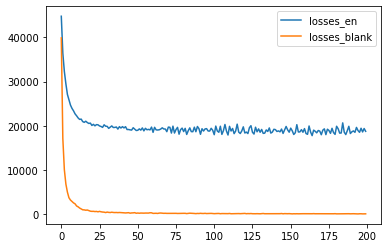

In [4]:
import matplotlib.pyplot as plt

plt.plot(losses_en)
plt.plot(losses_blank)
plt.legend(['losses_en', 'losses_blank'])
plt.show()

## Test model with *displacy*
*displacy* function can visualise the NER prediction in a concise way shown below. We can found that the results predicted by two models are pretty similar or the same. Hence, the two model might have the similar performance.

In [5]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


from spacy import displacy

for i in range(10):
    test_text = TEST_DATA[i][0]
    doc = nlp_en(test_text)
    printmd('**NER trained from en_core_web_sm**')
    displacy.render(doc, style="ent")

    doc = nlp_blank(test_text)
    printmd('**NER trained from blank model**')
    displacy.render(doc, style="ent")
    print("========================")

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

**NER trained from en_core_web_sm**

**NER trained from blank model**

## Test model with statistics
In this section, recall, precision and F1-score will be computed to analyse the performance. We can find that both of the two model have the good performance. To find the better one, we need to apply paired t-test; however, it will take too much time and is not the goal of this project so just leave this analysis in the future.

In [6]:
from spacy.gold import GoldParse
from spacy.scorer import Scorer

def evaluate(ner_model, test_set):
    scorer = Scorer()
    for sen in test_set:
        doc_gold_text = ner_model.make_doc(sen[0])
        gold = GoldParse(doc_gold_text, entities=sen[1]['entities'])
        pred_value = ner_model(sen[0])
        scorer.score(pred_value, gold)
    return scorer.scores


In [7]:
results_blank = evaluate(nlp_blank, TEST_DATA)
results_en = evaluate(nlp_en, TEST_DATA)

In [8]:
printmd('**NER trained from en_core_web_sm**')
print(f"Precision: {results_en['ents_p']}, Recall: {results_en['ents_r']}, F1-Score: {results_en['ents_f']}")

**NER trained from en_core_web_sm**

Precision: 93.18820224719101, Recall: 92.56417410714286, F1-Score: 92.87513997760357


In [9]:
printmd('**NER trained from blank model**')
print(f"Precision: {results_blank['ents_p']}, Recall: {results_blank['ents_r']}, F1-Score: {results_blank['ents_f']}")

**NER trained from blank model**

Precision: 93.73394233514131, Recall: 91.61551339285714, F1-Score: 92.66262170170735


## Save Model

In [10]:
nlp_blank.to_disk('../model/ENR_blank')
nlp_en.to_disk('../model/ENR_en')